# Converting MNIST IDX binary format to NumPy arrays

WNixalo – 2018/5/20

In [1]:
from pathlib import Path
import numpy as np
import os
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
%matplotlib inline

## Download MNIST

In [2]:
def download_mnist(path=Path('data/mnist')):
    os.makedirs(path, exist_ok=True)
    urls = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',]
    for url in urls:
        fname = url.split('/')[-1]
        if not os.path.exists(path/fname): urlretrieve(url, path/fname)

## Conversions

See: https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40

In [3]:
import struct
import gzip
import numpy as np

def read_IDX(fname):
    """see: https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40"""
    with gzip.open(fname) as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
# See: https://docs.python.org/3/library/struct.html#byte-order-size-and-alignment
# IDX format assumes MSB (big-endian) ordering used by non-Intel machines.
# Therefore if you're using an Intel cpu specify '>' when unpacking to let 
# Python know to handle the header bytes correctly

In [12]:
download_mnist()

In [26]:
fname = Path('data/mnist/t10k-images-idx3-ubyte.gz')
tmp = read_IDX(fname)

In [30]:
tmp.shape

(10000, 28, 28)

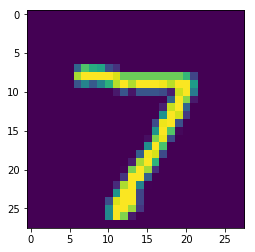

In [29]:
plt.imshow(tmp[0])

Sweet!

Making sure I can see the labels:

In [82]:
tmp = None
fname = Path('data/mnist/t10k-labels-idx1-ubyte.gz')
tmp   = read_IDX(fname)

In [83]:
tmp.shape

(10000,)

In [86]:
tmp

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [85]:
set(tmp)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Okay, cool.

---

## Understanding Unpacking

The [MNIST website](http://yann.lecun.com/exdb/mnist/) says:
> All integers in the files are stored in MSB first (high endian) format used by most non-Intel processors. Users of Intel processors and other low-endian machines must flip the bytes of the header.

But I seem to get the same output when I specify `struct.unpack('>HBB', f.read(4))` or `struct.unpack('HBB', f.read(4))` ... but according to the [Python docs 7.1.2.1](https://docs.python.org/3/library/struct.html#byte-order-size-and-alignment):
> the first character of the format string can be used to indicate the byte order, size, and alignment of the packed data .. if the first character is none of these, `@` is assumed.

`@` is native; `>` is big-endian, `<` is little-endian.

After some debugging, with a `set_trace` right before the first unpacking:

    (Pdb) struct.unpack('>HBB', f.read(4))
    (0, 8, 3)
    
    (Pdb) struct.unpack('HBB', f.read(4))
    (0, 8, 3)
    
    (Pdb) struct.unpack('<HBB', f.read(4))
    (0, 8, 3)
    
All three give the same output. The return values from unpacking 4 more times are also identical:

    (Pdb) struct.unpack('>HBB', f.read(4))
    (0, 39, 16)
    (Pdb) struct.unpack('>HBB', f.read(4))
    (0, 0, 28)
    (Pdb) struct.unpack('>HBB', f.read(4))
    (0, 0, 28)
    (Pdb) struct.unpack('>HBB', f.read(4))
    (0, 0, 0)

    (Pdb) struct.unpack('HBB', f.read(4))
    (0, 39, 16)
    (Pdb) struct.unpack('HBB', f.read(4))
    (0, 0, 28)
    (Pdb) struct.unpack('HBB', f.read(4))
    (0, 0, 28)
    (Pdb) struct.unpack('HBB', f.read(4))
    (0, 0, 0)

    (Pdb) struct.unpack('<HBB', f.read(4))
    (0, 39, 16)
    (Pdb) struct.unpack('<HBB', f.read(4))
    (0, 0, 28)
    (Pdb) struct.unpack('<HBB', f.read(4))
    (0, 0, 28)
    (Pdb) struct.unpack('<HBB', f.read(4))
    (0, 0, 0)
    
*However*, the 2nd unpacking line: `shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))` is the important one. `I` reads in data in the unsigned int format (see [Python docs 7.1.2.2](https://docs.python.org/3/library/struct.html#format-characters)).

The important part from the first unpacking was `dims`. `dims = 3` from the first unpacking. Using that to iterate the next unpacking using `'>I'` creates a tuple of the first element of each tuple unpacked from the IDX file. The unpacked tuples via `f.read(4)` look at the first `4` bytes of the file.

For the image IDX files this gets you:

    (Pdb) struct.unpack('>I', f.read(4))[0]
    10000
    (Pdb) struct.unpack('>I', f.read(4))[0]
    28
    (Pdb) struct.unpack('>I', f.read(4))[0]
    28
    
The next unpack(..)[0] would return 0.

Similarly, `dims = 1` for the labels IDX file, being a single vector, and the output is:

    (Pdb) struct.unpack('>I', f.read(4))[0]
    10000
    
Just to make sure, I took a look at the entire unpacked tuple, and it's just this:

    (Pdb) struct.unpack('>I', f.read(4))
    (10000,)
    (Pdb) struct.unpack('>I', f.read(4))
    (28,)
    (Pdb) struct.unpack('>I', f.read(4))
    (28,)
    
So the `[0]` indexing is just extracting the number inside.

With all this, I don't know exactly why `>HBB` can by `HBB`, but I can appreciate that it's purpose is to extract the number of dimensions of the data, which is used with `>I` (high-endian unsigned integer formatting) to find the shape of the data's dimensions.

That information is then used by NumPy to reshape the data. **NOTE** `np.fromstring` was originally used but it's now deprecated: `np.frombuffer` is used instead.

In [32]:
def read_IDX(fname):
    with gzip.open(fname) as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        import pdb; pdb.set_trace()
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [33]:
# fname = Path('data/mnist/t10k-labels-idx1-ubyte.gz')
fname = Path('data/mnist/t10k-images-idx3-ubyte.gz')
tmp   = read_IDX(fname)

> <ipython-input-32-58402d389d9a>(5)read_IDX()
-> shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
(Pdb) q


BdbQuit: 

## Alternate Conversion Method

There's another (similar) way to do this, but what I haven't tested it.

See: https://medium.com/@mannasiladittya/converting-mnist-data-in-idx-format-to-python-numpy-array-5cb9126f99f1

In [ ]:
## see: https://medium.com/@mannasiladittya/converting-mnist-data-in-idx-format-to-python-numpy-array-5cb9126f99f1
# 1. imports
import struct
import numpy as np

# 2. open IDX file in readable binary mode
fname = {'images': 'train-images-idx3-ubyte', 'labels':'train-labels-idx1-ubyte'}
fimg  = open('data/mnist/' + fname['images'], 'rb')

# 3. read magic number
fimg.seek(0)
magic = struct.unpack('>4B', fimg.read(4))

# 4. read dims of image dataset
nimg = struct.unpack('>I', fimg.read(4))[0] # num images
nrow= struct.unpack('>I', fimg.read(4))[0] # num rows
ncol= struct.unpack('>I', fimg.read(4))[0] # num cols

# 5. create numpy array
img_arr = np.zeros((nimg, nrow, ncol))

# 6. read img data
n_bytes_total = nimg * nrow * ncol * 1 # since ea. pixel is 1 byte
img_arr = 255 - np.asarray(struct.unpack('>' + 'B' * n_bytes_total, fimg.read(n_bytes_total))
                          ).reshape((nimg, nrow, ncol))